# Probabilistic-Matrix-Factorization

- [Repositorio](https://github.com/fuhailin/Probabilistic-Matrix-Factorization/tree/master)

- [Paper](https://proceedings.neurips.cc/paper_files/paper/2007/hash/d7322ed717dedf1eb4e6e52a37ea7bcd-Abstract.html)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split
import pathlib

## 1. Cargar BD 'u.data'

    Unicamente devuelve las columnas user_id, item_id, rating

In [3]:
u_data = "data/u1.base"

def load_rating_data(u_data_path: pathlib.Path) -> np.ndarray:
    data = np.loadtxt(u_data_path, dtype=np.int64)
    # userId, itemId empiezan en 1 -> pasamos a base-0
    data[:, 0] -= 1
    data[:, 1] -= 1
    # Solamente queremos quedarnos con las columnas: user, item, rating (ignoramos timestamp)
    return data[:, :3].astype(np.float64)

ratings = load_rating_data(u_data)
n_users = int(ratings[:, 0].max()) + 1
n_items = int(ratings[:, 1].max()) + 1

print(f" {len(ratings)} registros de {n_users} usuarios que han valorado {n_items} películas")

 80000 registros de 943 usuarios que han valorado 1682 películas


## 2. Train /test

    Dividir el dataset en train (80%) y test(20%)

In [4]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"De los {len(ratings)} datos totales, "
      f"{len(train)} ({len(train)/len(ratings)*100:.0f}%) son para train "
      f"y {len(test)} ({len(test)/len(ratings)*100:.0f}%) para test.")

De los 80000 datos totales, 64000 (80%) son para train y 16000 (20%) para test.


## 3. Definir PMF

    (La Clase PMF es igual que la del repositorio)

In [5]:
class PMF(object):
    def __init__(self, num_feat=10, epsilon=1.0, _lambda=0.1, momentum=0.8,
                 maxepoch=20, num_batches=10, batch_size=1000,
                 early_stop_patience=None, tol=1e-8):
        self.num_feat = num_feat               # Nº de factores latentes
        self.epsilon = epsilon                 # Learning rate
        self._lambda = _lambda                 # L2 regularization
        self.momentum = momentum               # Momentum del gradiente
        self.maxepoch = maxepoch               # Nº máximo de épocas
        self.num_batches = num_batches         # Nº de batches por época
        self.batch_size = batch_size           # Tamaño de batch
        self.early_stop_patience = early_stop_patience  # Paciencia para early stopping (None = desactivado)
        self.tol = tol

        self.w_Item = None
        self.w_User = None

        self.rmse_train = []
        self.rmse_test = []
        self.best_epoch = None
        self.best_test_rmse = np.inf
        self.best_train_rmse = np.inf
        self.best_w_Item = None
        self.best_w_User = None

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", self.num_feat)
            self.epsilon = parameters.get("epsilon", self.epsilon)
            self._lambda = parameters.get("_lambda", self._lambda)
            self.momentum = parameters.get("momentum", self.momentum)
            self.maxepoch = parameters.get("maxepoch", self.maxepoch)
            self.num_batches = parameters.get("num_batches", self.num_batches)
            self.batch_size = parameters.get("batch_size", self.batch_size)
            self.early_stop_patience = parameters.get("early_stop_patience", self.early_stop_patience)
            self.tol = parameters.get("tol", self.tol)

    def fit(self, train_vec, test_vec):
        # media global
        self.mean_inv = np.mean(train_vec[:, 2])

        # limpiar históricos si reentrenas el mismo objeto
        self.rmse_train, self.rmse_test = [], []
        self.best_epoch = None
        self.best_test_rmse = np.inf
        self.best_train_rmse = np.inf
        self.best_w_Item = None
        self.best_w_User = None

        pairs_train = train_vec.shape[0]
        pairs_test = test_vec.shape[0]

        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1

        # inicialización
        self.epoch = 0
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)
        self.w_Item_inc = np.zeros((num_item, self.num_feat))
        self.w_User_inc = np.zeros((num_user, self.num_feat))

        # Para early stopping
        epochs_since_improve = 0

        while self.epoch < self.maxepoch:
            self.epoch += 1

            # barajar índices del train
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)

            # SGD por batches
            for batch in range(self.num_batches):
                idx = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(idx, shuffled_order.shape[0])

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # pred y error
                pred_out = np.sum(self.w_User[batch_UserID, :] * self.w_Item[batch_ItemID, :], axis=1)
                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # gradientes
                Ix_User = 2 * (rawErr[:, None] * self.w_Item[batch_ItemID, :]) + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * (rawErr[:, None] * self.w_User[batch_UserID, :]) + self._lambda * self.w_Item[batch_ItemID, :]

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Actualización con momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size
                self.w_Item -= self.w_Item_inc
                self.w_User -= self.w_User_inc

            # ---- Fin de época: calcular RMSE train/test ----
            pred_train = np.sum(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :] *
                                self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :], axis=1)
            err_train = pred_train - train_vec[:, 2] + self.mean_inv
            obj = np.linalg.norm(err_train) ** 2 + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)
            rmse_tr = np.sqrt(obj / pairs_train)

            pred_test = np.sum(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :] *
                               self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :], axis=1)
            err_test = pred_test - test_vec[:, 2] + self.mean_inv
            rmse_te = np.linalg.norm(err_test) / np.sqrt(pairs_test)

            self.rmse_train.append(rmse_tr)
            self.rmse_test.append(rmse_te)

            # >>>>>>>>>>>> PRINT FORMATEADO (4 decimales) <<<<<<<<<<<<
            print(f"Epoch: {self.epoch}, Training RMSE: {rmse_tr:.4f}, Test RMSE {rmse_te:.4f}")

            # Guardar mejor época (mínimo global de Test RMSE)
            if rmse_te + self.tol < self.best_test_rmse:
                self.best_test_rmse = rmse_te
                self.best_train_rmse = rmse_tr
                self.best_epoch = self.epoch
                # snapshot de pesos "best"
                self.best_w_Item = self.w_Item.copy()
                self.best_w_User = self.w_User.copy()
                epochs_since_improve = 0
            else:
                epochs_since_improve += 1

            # Early stopping (opcional)
            if (self.early_stop_patience is not None) and (epochs_since_improve >= self.early_stop_patience):
                print(f"[EarlyStopping] Sin mejora en Test RMSE por {self.early_stop_patience} épocas. Deteniendo en la época {self.epoch}.")
                break

        # ---- Mensaje de overfitting respecto a la época óptima ----
        if self.best_epoch is not None:
            print(f"Overfitting: Test RMSE mínimo en la Época {self.best_epoch} → "
                  f"Training RMSE: {self.best_train_rmse:.6f}, Test RMSE: {self.best_test_rmse:.6f}")
            # Restaurar mejores pesos
            self.w_Item = self.best_w_Item
            self.w_User = self.best_w_User

    def predict(self, user_id):
        return np.dot(self.w_Item, self.w_User[int(user_id), :]) + self.mean_inv

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])
        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


## 4. Definir modelo PMF

In [6]:
pmf = PMF()
pmf.set_params({
    "num_feat": 10,
    "epsilon": 1.0, # # Tasa de aprendizaje
    "_lambda": 0.1, 
    "momentum": 0.8,
    "maxepoch": 100,     # <-- épocas
    "num_batches": 100,
    "batch_size": 1000,
})

## 5. Entrenar modelo

In [7]:
pmf.fit(train, test)

Epoch: 1, Training RMSE: 1.1143, Test RMSE 1.1245
Epoch: 2, Training RMSE: 1.1109, Test RMSE 1.1237
Epoch: 3, Training RMSE: 1.1045, Test RMSE 1.1206
Epoch: 4, Training RMSE: 1.0886, Test RMSE 1.1104
Epoch: 5, Training RMSE: 1.0550, Test RMSE 1.0875
Epoch: 6, Training RMSE: 1.0111, Test RMSE 1.0590
Epoch: 7, Training RMSE: 0.9679, Test RMSE 1.0317
Epoch: 8, Training RMSE: 0.9309, Test RMSE 1.0088
Epoch: 9, Training RMSE: 0.9015, Test RMSE 0.9917
Epoch: 10, Training RMSE: 0.8784, Test RMSE 0.9805
Epoch: 11, Training RMSE: 0.8590, Test RMSE 0.9726
Epoch: 12, Training RMSE: 0.8422, Test RMSE 0.9673
Epoch: 13, Training RMSE: 0.8279, Test RMSE 0.9638
Epoch: 14, Training RMSE: 0.8149, Test RMSE 0.9615
Epoch: 15, Training RMSE: 0.8034, Test RMSE 0.9605
Epoch: 16, Training RMSE: 0.7927, Test RMSE 0.9603
Epoch: 17, Training RMSE: 0.7835, Test RMSE 0.9606
Epoch: 18, Training RMSE: 0.7752, Test RMSE 0.9607
Epoch: 19, Training RMSE: 0.7676, Test RMSE 0.9615
Epoch: 20, Training RMSE: 0.7610, Test R

## 6. Visualizar 


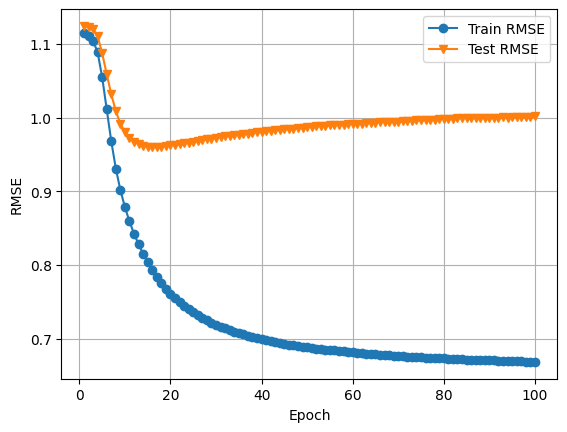

In [8]:
plt.plot(range(1, len(pmf.rmse_train)+1), pmf.rmse_train, marker='o', label='Train RMSE')
plt.plot(range(1, len(pmf.rmse_test)+1), pmf.rmse_test, marker='v', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()